In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchattacks
import requests
import os
from torchvision import models

In [18]:
import requests
import torch
import torch.nn as nn
import numpy as np
import json
import io
import sys
import base64
from torch.utils.data import Dataset
from typing import Tuple
import pickle
import os

cwd = os.getcwd()
print('cwd: ', cwd)

class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        #id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.imgs)


data = TaskDataset()

cwd:  c:\Users\HP\OneDrive\Documents\GitHub\Trustworthy-Machine-Learning


In [19]:
# transform to convert PIL image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

In [21]:
data: TaskDataset = torch.load("./Train.pt",transform)

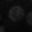

In [25]:
data[100][0]

In [5]:
os.makedirs("out/models", exist_ok=True)


In [12]:
# Create a dummy model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.weight.shape[1], 10)

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# DataLoader
data_loader = DataLoader(data, batch_size=32, shuffle=True)

In [14]:
for inputs, labels in data_loader:
    print(inputs.shape)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in data_loader:
        # Convert tensors to require_grad   
        adversarial_inputs = inputs.clone().detach().requires_grad_(True)
        labels = labels.clone().detach()
                
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(adversarial_inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

In [ ]:



#### SUBMISSION ####


torch.save(model.state_dict(), "out/models/dummy_submission.pt")

#### Tests ####
# (these are being ran on the eval endpoint for every submission)

allowed_models = {
    "resnet18": models.resnet18,
    "resnet34": models.resnet34,
    "resnet50": models.resnet50,
}
with open("out/models/dummy_submission.pt", "rb") as f:
    try:
        model: torch.nn.Module = allowed_models["resnet18"](weights=None)
        model.fc = torch.nn.Linear(model.fc.weight.shape[1], 10)
    except Exception as e:
        raise Exception(
            f"Invalid model class, {e=}, only {allowed_models.keys()} are allowed",
        )
    try:
        state_dict = torch.load(f, map_location=torch.device("cpu"))
        model.load_state_dict(state_dict, strict=True)
        model.eval()
        out = model(torch.randn(1, 3, 32, 32))
    except Exception as e:
        raise Exception(f"Invalid model, {e=}")

    assert out.shape == (1, 10), "Invalid output shape"


# Send the model to the server
response = requests.post("http://34.71.138.79:9090/robustness", files={"file": open("out/models/dummy_submission.pt", "rb")}, headers={"token": "TOKEN", "model-name": "resnet18"})

# Should be 400, the clean accuracy is too low
print(response.json())